In [1]:
import numpy as np
from scipy.misc import comb
from scipy import special
import matplotlib.pyplot as plt
from IPython.display import Image

# Eliminating nuisance parameters by integrating likelihood functions

The likelihood function forms the basis for many statistical inference techniques. For example, one could estimate the parameters of a model by maximizing the likelihood. The problem is that likelihood functions frequently contain more parameters than we care about. The inexplicable or uninteresting noise that buffets processes of interest has to be parameterized and accounted for in the likelihood function. As Berger et al. discuss in [this paper](https://projecteuclid.org/euclid.ss/1009211804), the existence of so-called ‘nuisance parameters’ severely hampers inference in many cases. The authors review a few of the common frequentist techniques for dealing with nuisance parameters in likelihood functions, but fall strongly in favor of integrating the likelihood function over the nuisance parameters. Although this method has a Bayesian flavor to it, the authors emphasize the practical benefits of integrated likelihoods, even for statisticians with more frequentist leanings.

Berger et al. present a number of scenarios where an integrated likelihood function forms a more robust basis for inference than the frequentist candidates. While some of the examples seem a little contrived, the benefit of using an integrated likelihood is demonstrated in Example 4 of the paper, which involves estimating a parameter from samples drawn from a binomial distribution. This example is explored in this Jupyter notebook.

Imagine that we’ve been challenged by a friend to estimate the number of times a coin has been flipped, $s$, in a series of $k$ independent sessions, but(!), we’re only told how many times the coin landed on heads. In each session, the coin is flipped N times, heads appears with a probability p, and both are unknown. How can we estimate N? The binomial distribution is the natural probabilistic model for this situation, and we can use it to construct a likelihood function for N given the number of times heads is drawn with p as the nuisance parameter. 

In this instance, the likelihood function, denoted $L(N,p)$, is the probability density of observing a series of success counts $\mathbf{s} = (s_1,s_2,..,s_k$) given $N$ and $p$:

$$ L(N,p) = \left [ \prod_{j=1}^k {{N}\choose{s_j}} \right ] p^T (1 - p)^{Nk - T} , \quad\quad\quad\quad 0 \leq p \leq 1, N\geq s_\text{max}$$

where the likelihood has been simplified with $T=\sum_j^k s_j$.

The code for $L(N,p)$ is as follows:

In [2]:
def likelihood(s,N,p):
    """ 
    The likelihood function for s observed successes given the number of trials N and probability of success p.

    Parameters
    ----------
    s : numpy array
      the number of observed success for multiple sessions
    N : float
      the number of trials
    p : float
      the probability of success for each trial
   
    Return
    ------
    float
      the likelihood

    """
    T = np.sum(s)
    k = len(s)
    if N >= s.max():
        return np.prod(comb(N,s)) * p**T * (1 - p)**(N*k - T)
    else:
        return 0

For numerical stability, it's usually more practical to deal with the log of the likelihood, but we'll follow Berger et al.'s notation. In particular, example 4 in the [paper](https://projecteuclid.org/euclid.ss/1009211804) considers $k=5$ with number of success

In [3]:
s = np.array((16,18,22,25,27))

for each repeat. We can see what the $L(N,p)$ looks like in 2D:

/Users/rossg/miniconda2/lib/python2.7/site-packages/matplotlib/tight_layout.py:222: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


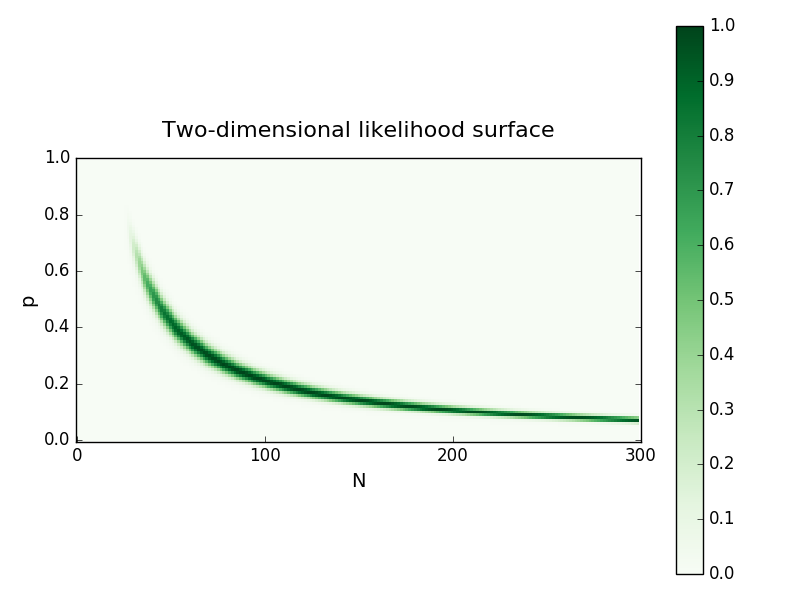

In [4]:
# Creating a 2D grid to evaluate L
N = np.linspace(1,300,200)
p = np.linspace(0,1,100)
L = np.zeros((len(N),len(p)))

for i in range(len(N)):
    for j in range(len(p)):
        L[i,j] = likelihood(s,N[i],p[j])

# Scaling the likelihood so its maximum is 1 for aesthetic reasons.        
L = L/L.max()      

# Plotting:
fig,ax = plt.subplots()

cax = ax.matshow(L.T,cmap=plt.cm.Greens,interpolation='none',origin='lower')
c = fig.colorbar(cax,ax=ax)
ax.xaxis.set_ticks_position('bottom')
ax.set_xticks(np.arange(0,200,66.66666666666))
ax.set_xticklabels(range(0,310,100))
ax.set_yticks(range(0,110,20))
ax.set_yticklabels(np.arange(0,1.2,0.2))
ax.set_xlabel('N',fontsize=14)
ax.set_ylabel('p',fontsize=14)
ax.set_title('Two-dimensional likelihood surface',fontsize=16)

plt.tight_layout()
plt.savefig('2D_Likelihood.png', format='png')
Image('2D_Likelihood.png')        

### The profile likelihood
One way to estimate N is to maximize the two-dimensional likelihood, then record the value of $N$ and discard the value of $p$. This is equivalent to maximizing the **profile likelihood** of N: the one-dimensional projection of the likelihood surface over the values of $p$ that maximise the likelihood for a give value of $N$. Formally, the profile likelihood is defined as

$$ \hat{L}(N) = \sup_p L(N,p)$$

In practice, deriving an expression for $\hat{L}(N)$ involves expressing $p$ as a function of $N$ that returns the supremum. In the example explored here, we can satisfy ourselves that $\hat{p}(N) = T/kN$ is the function we need. This gives

$$ \hat{L}(N) =  \left [ \prod_{j=1}^k {{N}\choose{s_j}} \right ] \left (\frac{T}{kN}\right )^T \left(1 - \frac{T}{kN}\right)^{Nk - T} , \quad\quad\quad\quad 0 \leq p \leq 1, N\geq s_\text{max}$$

In code form:

In [5]:
def profile_likelihood(s,N):
    """ 
    The profile likelihood function for s observed successes given the number of trials N.

    Parameters
    ----------
    s : numpy array
      the number of observed success for multiple indepentend events
    N : float
      the number of trials
   
    Return
    ------
    float
      the profile likelihood
    """
    T = np.sum(s)
    k = len(s)
    p_hat = T/(k*N)
    if N >= s.max():
        return np.prod(comb(N,s)) * p_hat**T * (1 - p_hat)**(N*k - T)
    else:
        return 0

### Conditional likelihood
An alternative way to reduce the dimensionality of the full likelihood is to condition it on the sufficient statistic of the data, creating the so-called **conditional likelihood**. While its use is uncommon, it's still informative to compare it to the other methods. To proceed, its worth stating the sufficient statistic for this example is, in fact, $T$.

As described above, the full likelihood, L(N,p), is the probability density for observing $\mathbf{s}$ given $N$ and $p$. Writing this density as $f(\mathbf{s} \, | \, N, p)$, we define the conditional likelihood as
$$
L^{C}(N) = \frac{f(\mathbf{s} \, | \, N, p)}{f(T \,|\, N, p)} \\
\quad\quad = f(\mathbf{s} \,|\, T, N) \\
$$
The density $f(T | N, p)$ is a piece of mathematical fiction, and we can think of it as the probility density of observing T sucesses (heads) in $kN$ trials, so that

$$ f(T| N, p) = {{kN}\choose{T}} p^T(1 - p)^{kN - T} $$

Giving

$$ L^{C}(N) = \left [ \prod_{j=1}^k {{N}\choose{s_j}} \right ] / {{kN}\choose{T}}, \quad\quad\quad\quad N\geq s_\text{max}$$

Notice how, mathemagically, the dependence on $p$ has disappeared. 

To evaluate $L^{C}(N)$ numerically, it's helpful to compute the log of the likelihood then take the exponent:

In [6]:
def chooseln(N, k):
    """ 
    The log of binomial coefficient. Useful for evaluating log likelihoods for binomial models.
    
    Parameters
    ----------
    N : float
      the number of possibilities
    k : float
      the number of outcomes
   
    Return
    ------
    float
      the log of the binomial coefficient
    """
    return special.gammaln(N+1) - special.gammaln(N-k+1) - special.gammaln(k+1)

def conditional_likelihood(s,N):
    """ 
    The conditional likelihood function for s observed successes given the number of trials N.

    Parameters
    ----------
    s : numpy array
      the number of observed success for multiple indepentend events
    N : float
      the number of trials
   
    Return
    ------
    float
      the conditional likelihood
    """
    T = np.sum(s)
    k = len(s)
    if N >= s.max():
        l = np.sum([chooseln(N,n) for n in s]) - chooseln(N*k,T)
        return np.exp(l)
    else:
        return 0

### Uniform-integrated likelihood
Instead of the profile and conditional likelihoods, Berger et al. recommend integrating the likelihood surface over $p$, which we can think of as approximately giving us the probability of observing N irrespective of the value of $p$. Specifically, we'll consider the uniform-integrated likelihood, defined as 

$$ L^{U}(N) = \int_0^1 L(N,p) dp$$

The Bayesian interpretation of $L^{U}(N)$ is more clearly seen by writing

$$ L^{U}(N) = \int_0^1 f(\mathbf{s} \, | \, N, p) \pi(p \,|\,N) dp $$

where $\pi(p \,|\,N)$ is conditional prior of $p$ given $N$. In this form, $L^{U}(N)$, is the expectation value of $f(\mathbf{s} \, | \, N, p)$ over $\pi(p \,|\,N)$. In practicallity, $\pi(p \,|\,N)$ amounts to how much 'weight' we put on each value of $p$. In this case, we're considering $\pi(p \,|\,N)=1$, so we put a _uniform_ weight over $p$. Other choices for $\pi(p \,|\,N)$ are, of course, possible but they won't be considered here.

In [7]:
def uniform_likelihood(s,N):
    """ 
    The uniform integrated likelihood function for s observed successes given the number of trials N.

    Parameters
    ----------
    s : numpy array
      the number of observed success for multiple indepentend events
    N : float
      the number of trials
   
    Return
    ------
    float
      the uniform integrated likelihood
    """
    T = np.sum(s)
    k = len(s)
    if N >= s.max():
        l = np.sum([chooseln(N,n) for n in s]) + special.gammaln(k*N -T + 1) - special.gammaln(k*N + 2)
        return np.exp(l)
    else:
        return 0

With our likelihoods defined and coded, we can see how they do for our data, $\mathbf{s}$.

In [8]:
N = np.linspace(1,300,100)
L_p = np.zeros(len(N))
L_c = np.zeros(len(N))
L_u = np.zeros(len(N))

for i in range(len(N)):
    L_p[i] = profile_likelihood(s,N[i])
    L_c[i] = conditional_likelihood(s,N[i])
    L_u[i] = uniform_likelihood(s,N[i])

# Scaling the likelihood so its maximum is 1 for aesthetic reasons.        
L_p = L_p/L_p.max()
L_c = L_c/L_c.max()
L_u = L_u/L_u.max()

# Evaluting the maximum values, if they exist...
argmax_Lu = np.round(N[np.where(L_u == L_u.max())[0][0]])
argmax_Lp = np.round(N[np.where(L_p == L_p.max())[0][0]])

print 'Value of N that maximises L_u = {0}'.format(int(argmax_Lu))
print 'Value of N that maximises L_p = {0}'.format(int(argmax_Lp))

Value of N that maximises L_u = 52
Value of N that maximises L_p = 98


**Plotting:**

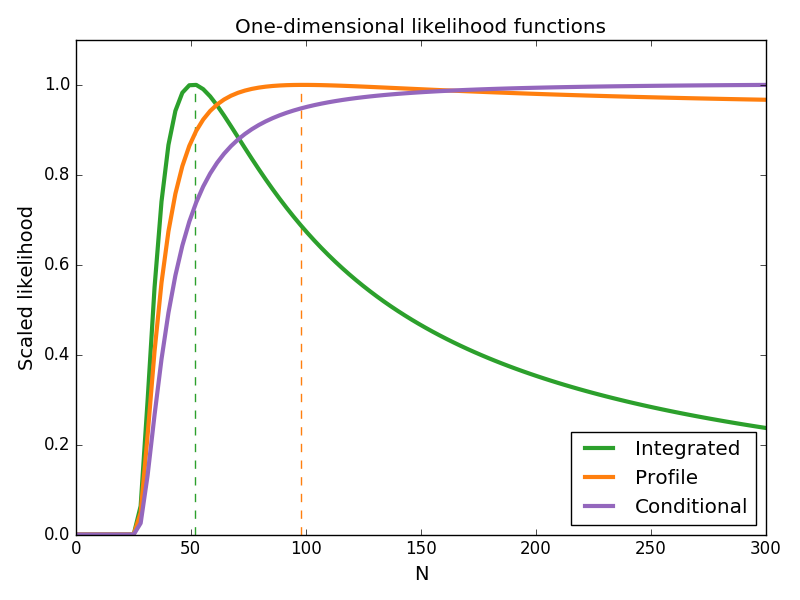

In [9]:
# These are the "Tableau" colors as RGB. I've chosen my faves. 
# In order: blue, green, purple, orange. 
# Scaling the RGB values to the [0, 1] range, which is the format matplotlib accepts. 
tableau4 = [(31, 119, 180),(44, 160, 44),(148,103,189),(255, 127, 14)]
for i in range(len(tableau4)):    
    r, g, b = tableau4[i]    
    tableau4[i] = (r / 255., g / 255., b / 255.)

plt.clf()
plt.plot(N,L_u,linewidth=3,color=tableau4[1])
plt.vlines(x=argmax_Lu,ymin=0,ymax=1,color=tableau4[1],linestyle='--')
plt.plot(N,L_p,linewidth=3,color=tableau4[3])
plt.vlines(x=argmax_Lp,ymin=0,ymax=1,color=tableau4[3],linestyle='--')
plt.plot(N,L_c,linewidth=3,color=tableau4[2])

plt.ylim((0,1.1))
plt.ylabel('Scaled likelihood',fontsize=14)
plt.xlabel('N',fontsize=14)
plt.legend(('Integrated','Profile','Conditional'), loc = 4)
plt.title('One-dimensional likelihood functions')

plt.tight_layout()
plt.savefig('1D_likelihoods.png',format='png')
Image('1D_likelihoods.png')

These three methods for eliminating the nuisance parameter p produce strikingly different likelihoods. As the conditional likelihood increases monotonically with N--- without limit---it provides no basis for maximum likelihood estimation. While both the integrated and profile likelihoods have well-defined maxima, the integrated likelihood has a maximum roughly half that of profile likelihood (shown in dotted lines). But which estimate is ‘better’? The curvature of the (log) likelihoods around the maximum is related to the uncertainty in our estimate of N. The fact that the integrated likelihood is more tightly peaked than the profile likelihood indicates that the maximum likelihood estimate is more robust than the estimate from the profile likelihood. As shown in Table 1 of the [paper](https://projecteuclid.org/euclid.ss/1009211804), repeating the entire coin flipping challenge and estimating N from the maximum of the profile likelihood produces a spread of estimates that is almost ten times as wide as the different estimates from the integrated likelihood. Therefore, in this case, the integrated likelihood is more practical than the conditional and profile likelihoods.